In [1]:

import torch
from taming.models.vqgan import VQModel
import numpy as np 
import matplotlib.pyplot as plt
import albumentations
import cv2

/home/student/andrewheschl/anaconda3/envs/taming/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
image_path = "/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/imagesTr/case_00000.npy"
image = np.load(image_path)
print(f"Image shape: {image.shape}, Image type: {type(image)}, Image dtype: {image.dtype}")
print(f"Min: {image.min()}, Max: {image.max()}")


mask_path = "/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/labelsTr/case_00000.npy"
mask = np.load(mask_path)
print(f"Image shape: {mask.shape}, Image type: {type(mask)}, Image dtype: {mask.dtype}")

rescaler = albumentations.SmallestMaxSize(max_size = 256)
cropper = albumentations.CenterCrop(height=256,width=256)
preprocessor = albumentations.Compose([rescaler, cropper])

image = np.transpose(image, (1,2,0))


dict = preprocessor(image=image)


Image shape: (3, 1024, 1024), Image type: <class 'numpy.ndarray'>, Image dtype: float32
Min: 0.0, Max: 1.0
Image shape: (1, 1024, 1024), Image type: <class 'numpy.ndarray'>, Image dtype: int8


In [11]:
mask_dict = rescaler(image=mask.squeeze())

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3598: error: (-215:Assertion failed) func != 0 in function 'resize'


In [12]:
mask_dict2 = rescaler(image=mask.transpose(1,2,0))

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3598: error: (-215:Assertion failed) func != 0 in function 'resize'


In [7]:
mask_dict2["image"].shape

(256, 256)

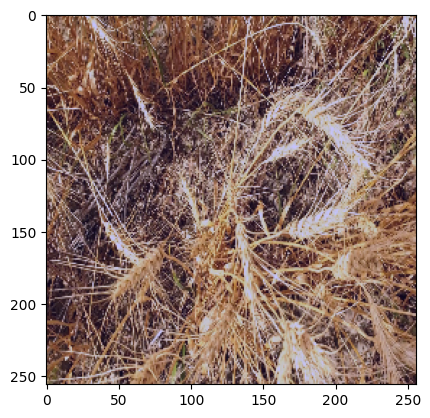

In [3]:
plt.imshow(dict['image'])

In [ ]:
plt.imshow(dict['mask'])

In [ ]:
model = VQModel(
    embed_dim=256,
    n_embed=1024,
    ddconfig={
        "double_z": False,
        "z_channels": 256,
        "resolution": 256,
        "in_channels": 3,
        "out_ch": 3,
        "ch": 128,
        "ch_mult": [1, 1, 2, 2, 4], # num_down = len(ch_mult)-1
        "num_res_blocks": 2,
        "attn_resolutions": [16],
        "dropout": 0.0,
    },
    lossconfig={
        "target": "taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator",
        "params": {
            "disc_conditional": False,
            "disc_in_channels": 3,
            "disc_start": 10000,
            "disc_weight": 0.8,
            "codebook_weight": 1.0,
        }
    },
    ckpt_path="/home/student/andrewheschl/Documents/DGDM_taming-transformers/logs/2024-10-21T18-04-03_custom_vqgan/checkpoints/last.ckpt"
)

In [ ]:
image_path = "/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/imagesTr/case_26312.npy"
image = torch.tensor(np.load(image_path)).unsqueeze(0)

import torchvision.transforms as T
rescaler = T.Resize((256,256))
image = rescaler(image)
print(image.shape)

image = image.permute(0,2,3,1)
print(image.shape)

batch = {"image": image}
log = model.log_images(batch)

In [ ]:
print(log["inputs"].min(),log["inputs"].max())
print(log["reconstructions"].min(),log["reconstructions"].max())

In [ ]:

plt.imshow(np.array(log["inputs"][0].permute(1,2 ,0).cpu().detach()))
plt.show()

In [ ]:
plt.imshow(np.array(log["reconstructions"][0].permute(1,2 ,0).cpu().detach()))
plt.show()

In [ ]:
image_path = "/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/imagesTr/case_00000.npy"
image = torch.tensor(np.load(image_path)).unsqueeze(0)

import torchvision.transforms as T
rescaler = T.Resize((256,256))
image = rescaler(image)
print(image.shape)


recon, _ = model(image)
print(recon.shape)
plt.imshow(recon[0].permute(1,2,0).cpu().detach())

In [ ]:
sd = torch.load("/home/student/andrewheschl/Documents/DGDM_taming-transformers/logs/2024-10-21T18-04-03_custom_vqgan/checkpoints/last.ckpt")
print(sd.keys())
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
print(sd["epoch"])
print(sd["callbacks"][ModelCheckpoint])